# Find highly (positively or negatively) correlated stocks
Finding stocks which has significant correlation, whether positive or negative, can be quite productive when buying/selling them. Furthermore, for predicting future movement of a stock, its fruitful to find stocks that can help in that prediction. 

In this context, this notebook finds highly correlated stocks using minute level data. In this case, we are using 2 minute data and considering Swedish stock exchange but the approach can be used for any such data in other exchanges.

### Import packages

In [1]:
import os 
import sys
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

dirPath = os.path.abspath('') #os.path.dirname(os.path.realpath(__file__))
p = os.path.abspath(dirPath+'/..')
if p not in sys.path:
    sys.path.append(p)
from trainDataReader import TrainDataReader

import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]

/Users/eullikr/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Helper functions
We use the following helper functions

In [2]:
def prepareDataForCorrAnalysis(dbTable, stocks, durationInDays, pickleFile = '/tmp/trainData.pickle'):
    if os.path.isfile(pickleFile):
        rawData = pd.read_pickle(pickleFile)
    else:
        trainDl = TrainDataReader(dbHost = os.environ['dbHost'], dbUser = os.environ['dbUser'], 
        dbPasswd = os.environ['dbPasswd'], dbName = 'omx', dbTable = dbTable, stocks = stocks)

        rawData = trainDl.readStockData(end_date = datetime.now(), numDays = trainDurInDays)
        rawData.to_pickle(pickleFile)

    # change format to put each stock as its own column
    stockDataWithNaN = pd.pivot_table(rawData, values ='Close', index =['Datetime'], columns =['Ticker'], aggfunc = np.sum) 
    # put previous value if current value is NaN
    stockData = stockDataWithNaN.ffill()

    # change absolute values percentage change
    stockDataPerc = stockData.pct_change() * 100

    return stockData, stockDataPerc

def get_end_date(df, startDate, granularity, amount):    
    assert(granularity in ['d', 'w', 'm']), "granularity should be 'd', 'w' or 'm'"
    if granularity == 'd':
        endDate = pd.to_datetime(startDate) + timedelta(days=amount)
    elif granularity == 'w':
        endDate = pd.to_datetime(startDate) + timedelta(weeks=amount)
    else:
        endDate = pd.to_datetime(startDate) + timedelta(months=amount)
    
    return np.min([datetime.now(), endDate])

def get_timebased_associations(df, granularity = 'w', amount = 1):
    corrMatrixList = dict()
    finalDate = np.max(df.index)
    startDate = np.min(df.index)
    while startDate < finalDate:
        endDate = get_end_date(df, startDate, granularity, amount)
        selData = df.loc[startDate:endDate].sort_index()
        #corrMatrixList.append(selData.corr())
        corrMatrixList[str(startDate.date())] = selData.corr()
        startDate = endDate

    return corrMatrixList

def get_significant_correlations(corrMatrixList, threshold = 0.5):
    if len(corrMatrixList) < 1:
        print('correlation matrix is empty')
        return
    else:
        stockPairs = []
        stockDf = pd.DataFrame()
        ctr = 0
        #for cmIndex in range(len(corrMatrixList)):
        for key in corrMatrixList.keys():
            #print('Starting for ' + key)
            corrMatrix = corrMatrixList[key]
            stockNames = corrMatrix.columns
            # reset lower diagonal to zero
            cm = corrMatrix.mask(np.tril(np.ones(corrMatrix.shape, dtype=np.bool_))).values
            indices = list(np.where(np.abs(cm) >= threshold))
            if indices[0].shape[0] > 0:
                sp = list()
                for i in range(indices[0].shape[0]):
                    s1 = stockNames[indices[0][i]]
                    s2 = stockNames[indices[1][i]]
                    if s1 < s2:
                        #entry = {'Stock1': s1, 'Stock2': s2, 'Correlation': corrMatrix.loc[s1,s2]}
                        entry = {'Stock1': s1, 'Stock2': s2, key : corrMatrix.loc[s1,s2]}
                    else:
                        #entry = {'Stock1': s2, 'Stock2': s1, 'Correlation': corrMatrix.loc[s1,s2]}
                        entry = {'Stock1': s2, 'Stock2': s1, key: corrMatrix.loc[s1,s2]}
                    sp.append(entry)
                if ctr == 0:
                    stockDf = pd.DataFrame(sp)
                    ctr = ctr + 1
                else:
                    stockDf = pd.merge(stockDf,pd.DataFrame(sp),on=['Stock1', 'Stock2'], how='outer')
                    #stockPairs.append((stockNames[indices[0][i]],stockNames[indices[1][i]]))
                stockPairs.append(sp)
            #print('Done for ' + key)
        
        #for key in corrMatrixList.keys():
        #    corrMatrix = corrMatrixList[key]
        #    for idx in stockDf.index:
        #        stockDf.loc[idx, key] = corrMatrix.loc[stockDf.Stock1[idx], stockDf.Stock2[idx]]

        return stockDf

### Get stocks to analyze

In [22]:
# get stocks
omxDf = pd.read_csv(dirPath+ '/../../docs/research/nasdaqOmxStocksInfo.csv')
outDir = os.path.join(dirPath,'../../data')
stocks = omxDf['yfSymbol'].apply(lambda x: x.replace('.ST', ''))    
stocks = stocks.tolist()
print('Some of the stocks we will analyse are:')
print(stocks[:10])

Some of the stocks we will analyse are:
['8TRA', 'AAK', 'ABB', 'ADDT-B', 'AF-B', 'ALFA', 'ALIV-SDB', 'AM1S', 'ARION-SDB', 'ARJO-B']


### Read data for the stocks

In [23]:
dbTable = 'Min2'
trainDurInDays = 150
outfile = os.path.join(outDir,'omxStocksRawData_'+dbTable+ '_DurDays' + str(trainDurInDays) + '.pickle')

# convert data to percentage change (from absolute values)
stockData, stockPercData = prepareDataForCorrAnalysis(dbTable = dbTable, stocks = stocks, durationInDays = 60, pickleFile = outfile)
stockPercData.set_index(pd.to_datetime(stockPercData.index), inplace=True)
stockPercData.tail()

Ticker,8TRA,AAK,ABB,ABLI,ACAD,ACE,ACTI,ADAPT,ADDT-B,AF-B,...,VSSAB-B,WALL-B,WBGR-B,WIHL,WISE,XANO-B,XBRANE,XSPRAY,XVIVO,ZETA
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-03-03 17:18:00,0.040225,0.027100,0.000000,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,...,0.0,0.169205,0.000000,0.121139,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-03 17:20:00,0.020105,0.054186,0.120676,0.0,0.0,-0.456621,0.000,-0.187266,0.0,0.000000,...,0.0,-0.084459,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-03 17:22:00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,...,0.0,0.084531,0.000000,0.000000,0.0,0.000000,0.980392,0.000000,0.154560,0.000000
2021-03-03 17:24:00,0.020101,-0.189548,0.040177,0.0,0.0,-0.114679,0.000,0.750469,0.0,0.340426,...,0.0,0.000000,0.000000,0.000000,0.0,-0.645161,0.485437,0.423729,0.000000,-0.326797
2021-03-03 17:28:00,0.060289,0.135648,0.080321,0.0,0.0,0.000000,-0.625,0.000000,0.8,0.000000,...,0.0,0.253378,-0.695134,-0.120992,0.0,0.000000,0.966184,0.000000,-0.308642,0.000000


### Clean data
We remove stocks or days which have all NaN

In [24]:
#stockPercData[stockPercData.apply(lambda x: )]
#spd = stockPercData.copy()
stockPercData = stockPercData.dropna(how = 'all', axis = 0).dropna(how = 'all', axis = 0)
#spd = spd.dropna(thresh=int(spd.shape[0]*0.66), axis=1)
stockPercData[np.isnan(stockPercData)] = 0
stockPercData

Ticker,8TRA,AAK,ABB,ABLI,ACAD,ACE,ACTI,ADAPT,ADDT-B,AF-B,...,VSSAB-B,WALL-B,WBGR-B,WIHL,WISE,XANO-B,XBRANE,XSPRAY,XVIVO,ZETA
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-12-30 12:02:00,0.000000,0.000000,-0.043783,0.0,-0.118765,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-30 12:04:00,0.000000,0.000000,-0.043802,0.0,0.118906,0.000000,-1.546392,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.053648,0.0,0.000000,0.000000,-0.305810,0.000000,0.000000
2020-12-30 12:06:00,0.303688,0.000000,0.043821,0.0,0.000000,-0.881834,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.306748,0.000000,0.000000
2020-12-30 12:08:00,-0.043253,-0.118238,0.000000,0.0,0.000000,0.000000,0.523560,0.000000,0.0,0.312744,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-30 12:10:00,0.000000,0.000000,0.000000,0.0,0.000000,0.177936,0.520833,0.000000,0.0,-0.077942,...,0.0,-0.152323,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-03 17:18:00,0.040225,0.027100,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.169205,0.000000,0.121139,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-03 17:20:00,0.020105,0.054186,0.120676,0.0,0.000000,-0.456621,0.000000,-0.187266,0.0,0.000000,...,0.0,-0.084459,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-03 17:22:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.084531,0.000000,0.000000,0.0,0.000000,0.980392,0.000000,0.154560,0.000000


### In case you want to analyse selected category of stocks

In [6]:
selCategory = 'Construction and Materials'
selStocks = omxDf[omxDf.Sector == selCategory].yfSymbol.apply(lambda x: x.replace('.ST',''))
selData = stockPercData[selStocks]

### Get associations based on daily movement
Below we find daily correlation for stocks. The idea is to find how stocks' correlation changes on daily basis. Then we can focus on the stock pairs whose correlation keeps reasonably consistent. Furthermore, we select stock pairs which have at least 60% correlation (negative or positive)

In [52]:
cmList = get_timebased_associations(stockPercData, granularity = 'd', amount = 1)
selStockPairsDaily = get_significant_correlations(cmList, threshold = 0.6)

/Users/eullikr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in greater_equal


Done for all



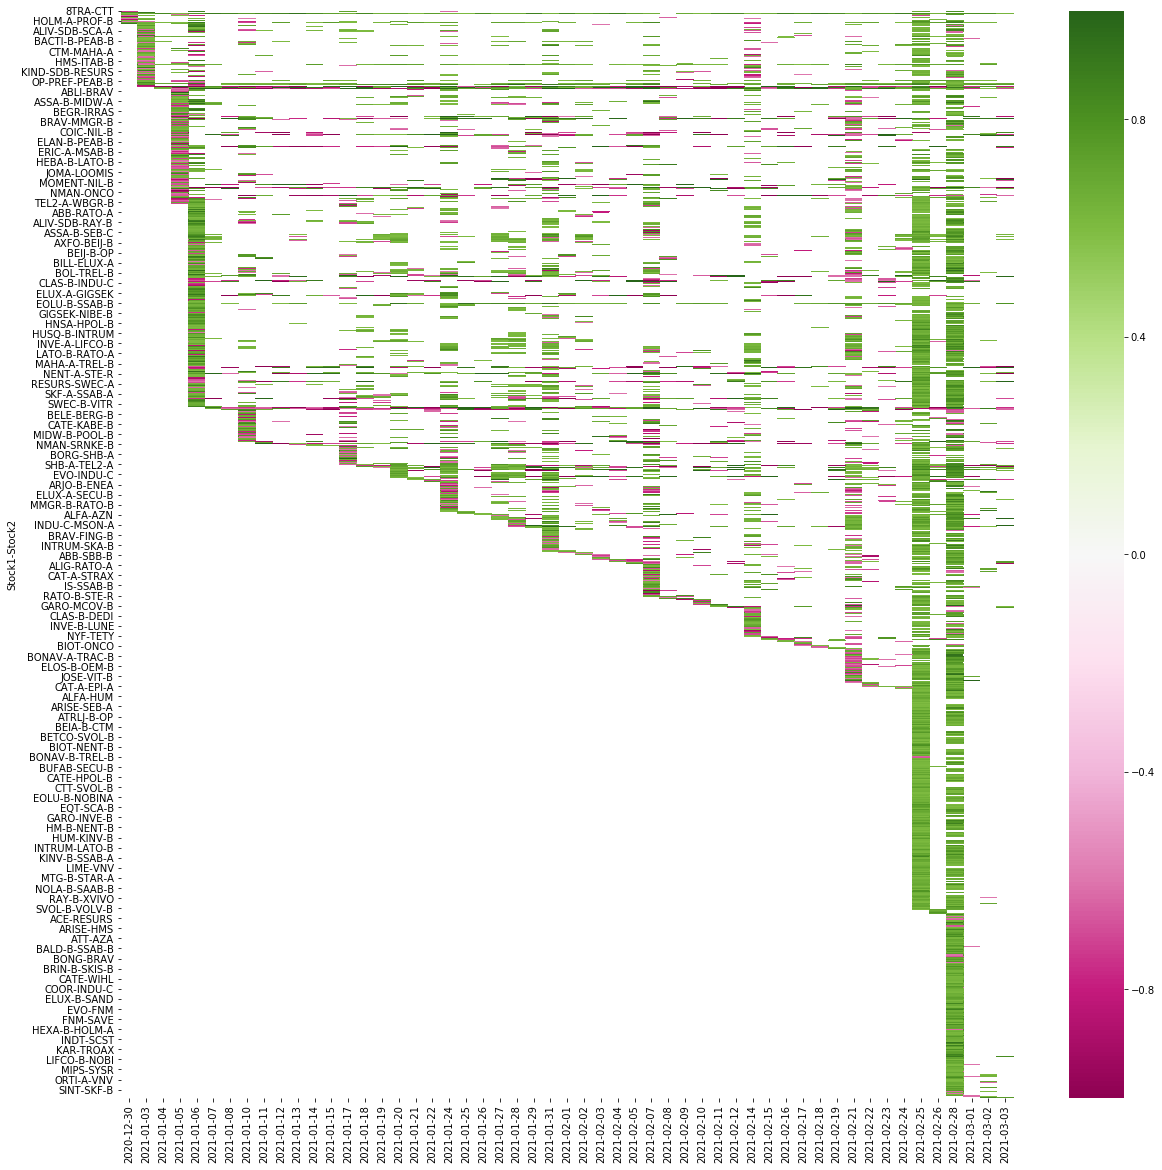

In [59]:
sns.heatmap(selStockPairsDaily.set_index(['Stock1', 'Stock2']), cmap="PiYG")
#sns.palplot(sns.color_palette("coolwarm", 12))
plt.show()

### Get associations based on weekly movement
Below we find weekly correlation for stocks. The idea is to find how stocks' correlation changes on weekly basis. Then we can focus on the stock pairs whose correlation keeps reasonably consistent. Furthermore, we select stock pairs which have at least 60% correlation (negative or positive)

In [60]:
cmList = get_timebased_associations(stockPercData, granularity = 'w', amount = 1)
selStockPairs = get_significant_correlations(cmList, threshold = 0.6)

/Users/eullikr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in greater_equal


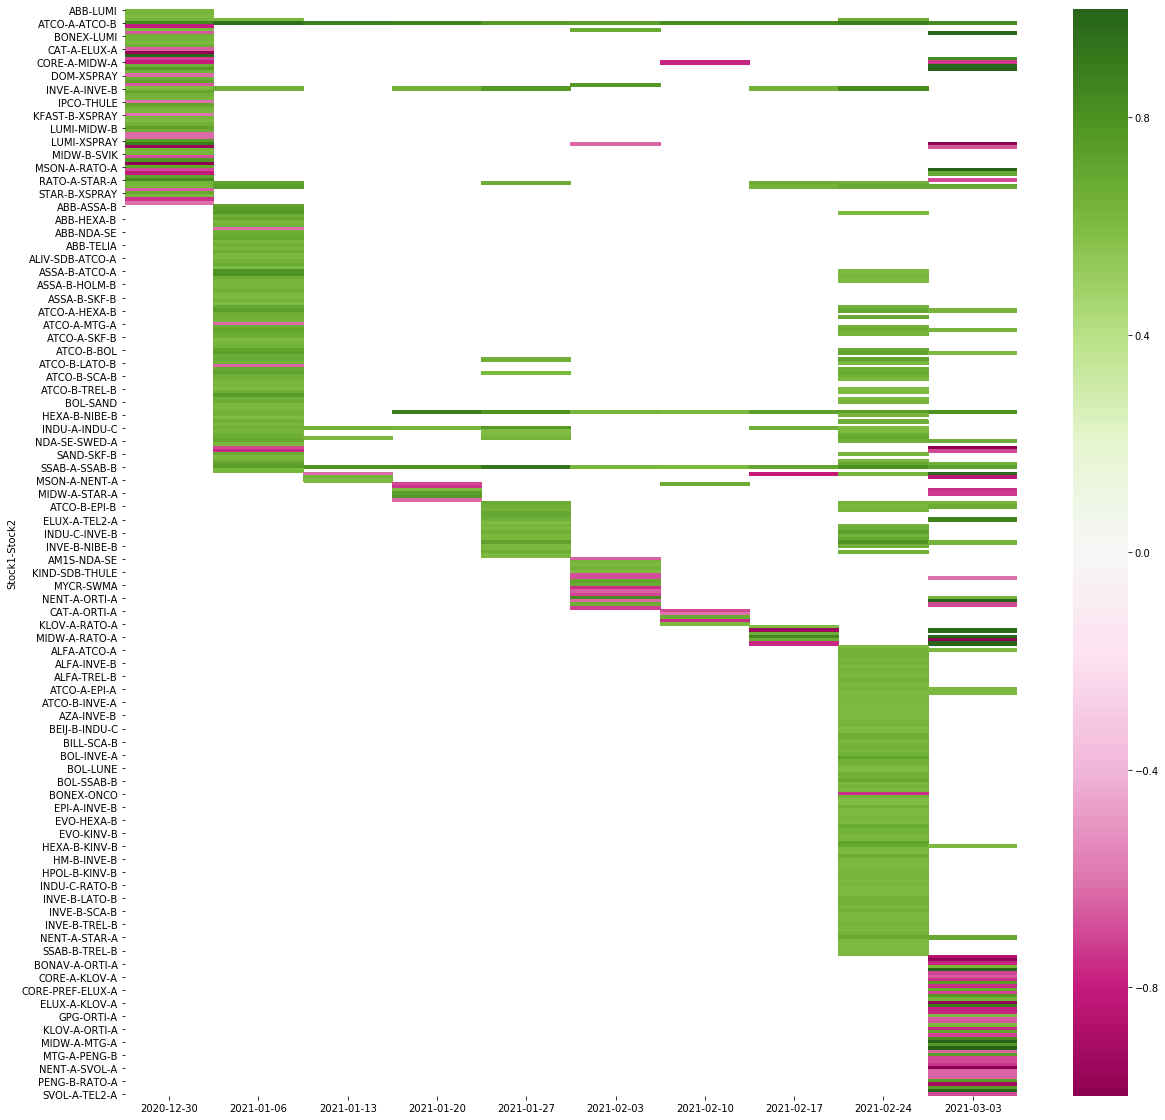

In [61]:
sns.heatmap(selStockPairs.set_index(['Stock1', 'Stock2']), cmap="PiYG")
plt.show()

In [ ]:
#sns.pairplot(selStockPairs.set_index(['Stock1', 'Stock2']).T,height=1)
#plt.show()

### Analysing some stock pairs
Let's see some stocks which have significant correlation as per above analysis.

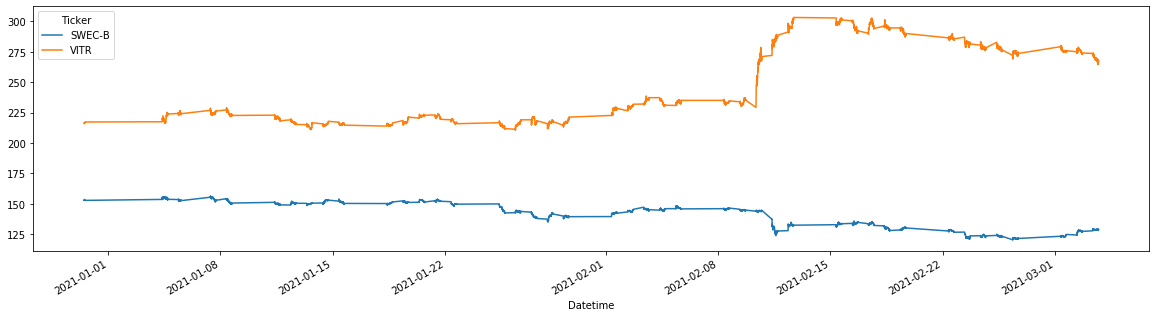

In [8]:
stockData[['SWEC-B', 'VITR']].plot(figsize=(20,5))
plt.show()

In [9]:
# show OHLC plot 
#stockData[['SWEC-B', 'VITR']].plot.oh
stOhlc = stockData.resample('5Min').ohlc()

In [13]:
import mplfinance as mpf
#from mpl_finance import candlestick
tick_bars=stOhlc['8TRA'].copy()
#mpf.plot(tick_bars,type='ohlc',mav=(7,12))
#mpf.plot(tick_bars,type='ohlc',mav=4)
#mpf.plot(stOhlc['ASSA-B'],type='ohlc',mav=4)
#plt.show()
#tick_bars['t'] = tick_bars['8TRA'].index.map(dates.date2num)
#stOhlc['8TRA'].plot(kind='ohlc')

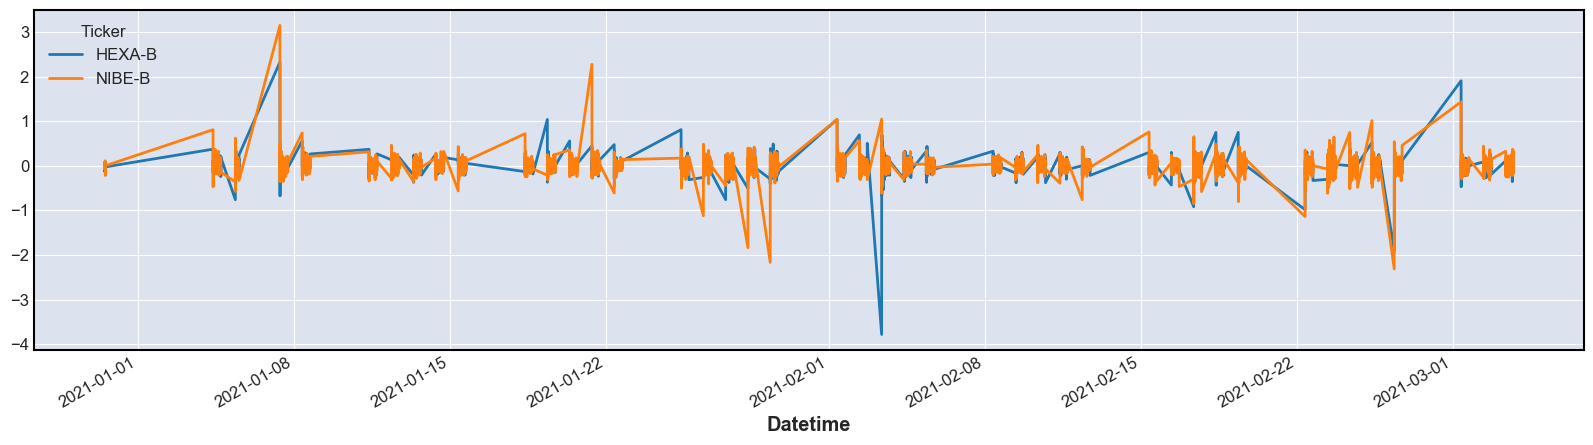

In [14]:
stockPercData[['HEXA-B', 'NIBE-B']].plot(figsize=(20,5))
plt.show()

## Finding forward associations between stocks
Next we try to find stock pairs that affect each other, i.e., increase/decrease in one stock drives increase/decrease in another stock within a specified time, e.g., 2 min, 5 min etc. For this we will use association rule mining to find support and confidence of such rules

In [120]:
from apyori import apriori

In [7]:
stockPercData

Ticker,8TRA,AAK,ABB,ABLI,ACAD,ACE,ACTI,ADAPT,ADDT-B,AF-B,...,VSSAB-B,WALL-B,WBGR-B,WIHL,WISE,XANO-B,XBRANE,XSPRAY,XVIVO,ZETA
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-12-30 12:02:00,0.000000,0.000000,-0.043783,0.0,-0.118765,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-30 12:04:00,0.000000,0.000000,-0.043802,0.0,0.118906,0.000000,-1.546392,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.053648,0.0,0.000000,0.000000,-0.305810,0.000000,0.000000
2020-12-30 12:06:00,0.303688,0.000000,0.043821,0.0,0.000000,-0.881834,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.306748,0.000000,0.000000
2020-12-30 12:08:00,-0.043253,-0.118238,0.000000,0.0,0.000000,0.000000,0.523560,0.000000,0.0,0.312744,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2020-12-30 12:10:00,0.000000,0.000000,0.000000,0.0,0.000000,0.177936,0.520833,0.000000,0.0,-0.077942,...,0.0,-0.152323,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-03 17:18:00,0.040225,0.027100,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.169205,0.000000,0.121139,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-03 17:20:00,0.020105,0.054186,0.120676,0.0,0.000000,-0.456621,0.000000,-0.187266,0.0,0.000000,...,0.0,-0.084459,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-03 17:22:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.084531,0.000000,0.000000,0.0,0.000000,0.980392,0.000000,0.154560,0.000000


In [25]:
observations = [[] for i in range(len(stockPercData))]

In [46]:
s10 = stockData.resample('10min').mean()
s10p = s10.pct_change() * 100
s10p

Ticker,8TRA,AAK,ABB,ABLI,ACAD,ACE,ACTI,ADAPT,ADDT-B,AF-B,...,VSSAB-B,WALL-B,WBGR-B,WIHL,WISE,XANO-B,XBRANE,XSPRAY,XVIVO,ZETA
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-12-30 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-30 12:10:00,0.119138,-0.059133,2.628121e-02,0.526316,0.023759,0.307510,-0.311850,-0.168067,0.000000,0.249805,...,NaN,-0.167555,NaN,0.021452,NaN,NaN,NaN,-0.107116,-0.128617,0.000000
2020-12-30 12:20:00,-0.164431,-0.325425,-3.503240e-02,0.785340,-0.023753,0.282985,0.104275,-0.042088,-0.535714,0.109017,...,NaN,0.030516,NaN,0.064343,NaN,NaN,-0.536193,0.306373,0.096587,0.000000
2020-12-30 12:30:00,-0.147365,-0.047489,-2.220446e-14,-1.038961,-0.261345,0.070547,-0.208333,0.000000,-0.359066,-0.124456,...,NaN,0.045760,0.101010,0.278641,NaN,NaN,0.000000,0.794136,-0.128659,0.000000
2020-12-30 12:40:00,-1.206702,-0.065328,8.761170e-03,-0.262467,0.071463,-0.070497,-0.208768,0.315789,0.540541,-0.109034,...,NaN,0.015246,0.504541,-0.032062,NaN,0.000000,0.323450,-0.424242,0.225443,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-03 16:40:00,0.016088,-0.204125,8.875978e-02,-1.114206,0.249546,0.776433,0.000000,0.150886,0.318979,0.204883,...,0.0,0.067590,0.000000,0.024210,0.0,0.000000,0.000000,0.000000,0.061671,0.000000
2021-03-03 16:50:00,0.136727,-0.527506,1.128668e-01,0.000000,-0.090518,-1.971448,0.251572,0.075330,0.000000,0.051116,...,0.0,-0.033772,0.000000,-0.048409,0.0,0.000000,0.098039,0.000000,-0.061633,0.000000
2021-03-03 17:00:00,-0.136541,-0.010823,1.530037e-01,0.000000,0.249151,0.577901,0.376412,0.301091,0.000000,0.051090,...,0.0,0.000000,0.297030,0.072648,0.0,-0.256410,0.195886,0.000000,0.061671,0.000000


In [47]:
s10

Ticker,8TRA,AAK,ABB,ABLI,ACAD,ACE,ACTI,ADAPT,ADDT-B,AF-B,...,VSSAB-B,WALL-B,WBGR-B,WIHL,WISE,XANO-B,XBRANE,XSPRAY,XVIVO,ZETA
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-12-30 12:00:00,230.8250,169.1100,228.30,0.760,84.18,56.366667,1.9240,95.20,112.00,256.20,...,NaN,131.30,NaN,186.46,NaN,NaN,NaN,163.375,311.000,14.750
2020-12-30 12:10:00,231.1000,169.0100,228.36,0.764,84.20,56.540000,1.9180,95.04,112.00,256.84,...,NaN,131.08,NaN,186.50,NaN,NaN,74.60,163.200,310.600,14.750
2020-12-30 12:20:00,230.7200,168.4600,228.28,0.770,84.18,56.700000,1.9200,95.00,111.40,257.12,...,NaN,131.12,99.000,186.62,NaN,NaN,74.20,163.700,310.900,14.750
2020-12-30 12:30:00,230.3800,168.3800,228.28,0.762,83.96,56.740000,1.9160,95.00,111.00,256.80,...,NaN,131.18,99.100,187.14,NaN,128.0,74.20,165.000,310.500,14.750
2020-12-30 12:40:00,227.6000,168.2700,228.30,0.760,84.02,56.700000,1.9120,95.30,111.60,256.52,...,NaN,131.20,99.600,187.08,NaN,128.0,74.44,164.300,311.200,14.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-03 16:40:00,248.6700,185.7800,248.08,0.710,88.38,44.130000,1.5900,106.20,125.80,234.76,...,54.2,118.44,101.000,165.26,35.7,156.0,102.00,118.000,324.500,15.300
2021-03-03 16:50:00,249.0100,184.8000,248.36,0.710,88.30,43.260000,1.5940,106.28,125.80,234.88,...,54.2,118.40,101.000,165.18,35.7,156.0,102.10,118.000,324.300,15.300
2021-03-03 17:00:00,248.6700,184.7800,248.74,0.710,88.52,43.510000,1.6000,106.60,125.80,235.00,...,54.2,118.40,101.300,165.30,35.7,155.6,102.30,118.000,324.500,15.300


In [62]:
sdp = stockData.pct_change() * 100

In [69]:
sdp

Ticker,8TRA,AAK,ABB,ABLI,ACAD,ACE,ACTI,ADAPT,ADDT-B,AF-B,...,VSSAB-B,WALL-B,WBGR-B,WIHL,WISE,XANO-B,XBRANE,XSPRAY,XVIVO,ZETA
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-12-30 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-30 12:02:00,NaN,0.000000,-0.043783,0.0,-0.118765,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN
2020-12-30 12:04:00,0.000000,0.000000,-0.043802,0.0,0.118906,NaN,-1.546392,0.000000,NaN,NaN,...,NaN,0.000000,NaN,0.053648,NaN,NaN,NaN,-0.305810,0.000000,NaN
2020-12-30 12:06:00,0.303688,0.000000,0.043821,0.0,0.000000,-0.881834,0.000000,0.000000,NaN,NaN,...,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,0.306748,0.000000,NaN
2020-12-30 12:08:00,-0.043253,-0.118238,0.000000,0.0,0.000000,0.000000,0.523560,0.000000,NaN,0.312744,...,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-03 17:18:00,0.040225,0.027100,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.169205,0.000000,0.121139,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-03 17:20:00,0.020105,0.054186,0.120676,0.0,0.000000,-0.456621,0.000000,-0.187266,0.0,0.000000,...,0.0,-0.084459,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2021-03-03 17:22:00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.084531,0.000000,0.000000,0.0,0.000000,0.980392,0.000000,0.154560,0.000000


In [132]:
sdp['XSPRAY'][sdp['XSPRAY'] > 0.1]

Datetime
2020-12-30 12:06:00    0.306748
2020-12-30 12:18:00    0.306748
2020-12-30 12:28:00    0.611621
2020-12-30 12:30:00    0.303951
2020-12-30 12:46:00    0.304878
                         ...   
2021-03-03 12:22:00    0.851064
2021-03-03 12:50:00    0.425532
2021-03-03 14:50:00    0.423729
2021-03-03 14:54:00    0.423729
2021-03-03 17:24:00    0.423729
Name: XSPRAY, Length: 1353, dtype: float64

In [67]:
sdp.apply(lambda x: len(x[x > 1]))/sdp.shape[0] * 100

Ticker
8TRA      0.075707
AAK       0.047317
ABB       0.028390
ABLI      4.845273
ACAD      0.160878
            ...   
XANO-B    1.599319
XBRANE    0.813854
XSPRAY    0.917952
XVIVO     0.264976
ZETA      0.662440
Length: 385, dtype: float64

In [136]:
thr = 0.01
sdpB = sdp.copy()
#sdpB = sdpB.apply(lambda x: x > thr = 1)
#sdpB = sdpB.apply(lambda x: x <= thr = 0)
sdpB[sdpB > thr] = 1
sdpB[sdpB <= thr] = 0
sdpB[np.isnan(sdpB)] = 0
sdpB = sdpB.astype(int)
#sdpB[np.isnan(sdpB)] = 0
sdpB #.apply(lambda x: len(x[x == 1]))/sdpB.shape[0] * 100
snp = sdpB.values.tolist()

In [137]:
arules = apriori(snp, min_support=0.0001, min_confidence=0, min_lift=0, min_length=2)

In [138]:
ptr = sdpB.apply(lambda x: len(x[x>1]) > 1, axis=1)
sdpB[ptr]

Ticker,8TRA,AAK,ABB,ABLI,ACAD,ACE,ACTI,ADAPT,ADDT-B,AF-B,...,VSSAB-B,WALL-B,WBGR-B,WIHL,WISE,XANO-B,XBRANE,XSPRAY,XVIVO,ZETA
Datetime,,,,,,,,,,,,,,,,,,,,,


In [19]:
selData[selData <= 0] = 0
selData[selData > 0] = 1

Ticker,8TRA,AAK,ABB
Datetime,,,
2020-12-30 12:02:00,0.0,0.0,0.0
2020-12-30 12:04:00,0.0,0.0,0.0
2020-12-30 12:06:00,1.0,0.0,1.0
2020-12-30 12:08:00,0.0,0.0,0.0
2020-12-30 12:10:00,0.0,0.0,0.0
2020-12-30 12:12:00,0.0,1.0,1.0
2020-12-30 12:14:00,0.0,0.0,0.0
2020-12-30 12:16:00,0.0,0.0,1.0
2020-12-30 12:18:00,0.0,0.0,0.0


In [15]:
stockPercData.iloc[:5,:3].values.tolist()

[[0.0, 0.0, -0.04378283712784814],
 [0.0, 0.0, -0.04380201489269098],
 [0.30368763557482303, 0.0, 0.043821209465400024],
 [-0.04325259515570723, -0.11823825007390987, 0.0],
 [0.0, 0.0, 0.0]]